## YouTube Dislike Button Remains, with Number of Dislikes Hidden from Public
* On November 10, 2021, YouTube announced that video **dislike counts** will be hidden from the public.  The stated benefit is protecting creators (especially smaller ones) from dislike attacks and harassment.
* The number of dislikes is only available in Studio to content creators.
* Announcement and Comments: https://support.google.com/youtube/thread/134791097/update-to-youtube-dislike-counts?hl=en

### Chrome Notes
* Ctrl + Shift + i to inspect elements of Chrome webpage.
* Save Chrome html webpage: Three-dot menu (top-right) > More tools > Save page as

In [1]:
import requests
from lxml import html
import re
import numpy as np
import statistics

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#NLP fun
from nltk import tokenize
from flair.models import TextClassifier
from flair.data import Sentence
flair = TextClassifier.load('en-sentiment')

#Monitor apply progress.
from ipywidgets import FloatProgress
from tqdm.notebook import tqdm
tqdm.pandas()

#DataFrame format
pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

2021-11-23 16:58:28,738 loading file C:\Users\Justin\.flair\models\sentiment-en-mix-distillbert_4.pt


In [2]:
#How flair (distilbert) scores a sentence.
sent = Sentence('This change is desireable.')
flair.predict(sent)
sent.labels[0].to_dict()

{'value': 'POSITIVE', 'confidence': 0.9952698349952698}

In [3]:
#We will insert a minus sign for NEGATIVE sentiment.
sent = Sentence('This change is not desireable.')
flair.predict(sent)
mydict = sent.labels[0].to_dict()
mydict['confidence'] = - mydict['confidence'] #flip to negative number.
mydict

{'value': 'NEGATIVE', 'confidence': -0.9991787075996399}

In [4]:
#Helper functions

def clean_dt(date_string):
    """Convert date to dd/mm/yy format."""    
    if pd.isna(date_string):
        return date_string
    
    result = re.sub('6 days', '11/16/21',date_string)
    result = re.sub('5 days', '11/17/21', result)
    result = re.sub('4 days', '11/18/21', result)
    result = re.sub('3 days', '11/19/21', result)
    result = re.sub('2 days', '11/20/21', result)
    result = re.sub('1 day', '11/21/21', result)
    result = re.sub('(\d+\shr|\d+\smin)', '11/22/21', result)
    return result

def clean_comm(raw):
    """ Remove hyperlinks and markup """
    
    if pd.isna(raw):
        return raw
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub("\n", '', result)
    result = re.sub("\.,", '. ', result)
    result = re.sub("\xa0,?", ' ', result)
    return result

def make_sentences(text):
    """ Split text into list of sentences """
    if pd.isna(text):
        return 0    
    sentences = tokenize.sent_tokenize(text)
    return sentences

def get_flair_scores(sentences):
    """ Call predict on every sentence of a text """
    flair_scores = []
    try:        
        for i in range(0, len(sentences)): 
            flair_scores.append(predict_flair(sentences[i]))
    except:
        return 0
    return flair_scores

def predict_flair(sentence):
    """ Predict the sentiment of a sentence """
    if sentence == "":
        return 0
    text = Sentence(sentence)    
    flair.predict(text)
    value = text.labels[0].to_dict()['value'] #flair prediction is method on text.
    if value == 'POSITIVE':
        result = text.to_dict()['labels'][0]['confidence']
    else:
        result = -(text.to_dict()['labels'][0]['confidence'])
    return round(result, 3)

def get_average(scores):
    try:
        result = round(statistics.mean(scores), 3)
    except:
        return 0
    return result

def get_histogram(numpy_array: np.array, log_scale_on: bool, num_bins: int):
    '''Do sanity check'''
    from matplotlib.ticker import MaxNLocator
    fig, ax1 = plt.subplots(1,1,figsize=(12,6))       
    ax1.axvline(x=np.mean(numpy_array), color = 'green', ls='--', alpha=1,  linewidth=3)    
    ax1.axvline(x=np.median(numpy_array), color = 'orange', ls='--', alpha=1,  linewidth=3)
    #ax1.axvline(x=np.min(numpy_array), color = 'black', ls='--', alpha=1, linewidth=3)
    #ax1.axvline(x=np.max(numpy_array), color = 'black', ls='--', alpha=1,  linewidth=3)
    #ax1.set(xlim=(-1.1, 1.1))
    
    ax1.set_title(f'Histogram stats:\n median (orange dashes): {np.round(np.median(numpy_array),3)}; mean (green dashes): {np.round(np.mean(numpy_array),3)}; \nmin: {np.round(np.min(numpy_array),3)}; max:{np.round(np.max(numpy_array),3)}')
    ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
    sns.histplot(numpy_array, ax=ax1, kde=False, log_scale=log_scale_on, bins=num_bins)
    plt.show()

In [5]:
#Open file and read into parser.  With statement automatically closes file.
with open('update_to_youtube_dislike_counts.html', 'r', encoding='UTF-8') as f:
    parser = html.fromstring(f.read())  #f.read() is a string containing the html page.

In [6]:
#Get comment count.
comment = '//div[@class="thread-all-replies__message"]'
qry_result = parser.xpath(comment)
tot_comments = len(qry_result)
print('Total Comments:', tot_comments, '\n')

Total Comments: 613 



In [7]:
#Save comments to list "l".
comment_num = 1
l = []
dates = []
for comment in range(1, tot_comments+1):
    commentText = f'//div[@class="thread-all-replies__message"]\
    [{comment_num}]//div[@class="thread-message__payload"]/descendant-or-self::*/text()'  #https://stackoverflow.com/questions/10413649/xpath-to-get-all-the-childrens-text/58616182
    
    commentDate = f'//div[@class="thread-all-replies__message"][{comment_num}]//div[@class="thread-message-header__right-block"]/time/text()'    
    
    comment_i_list = parser.xpath(commentText)
    comment_i_date = parser.xpath(commentDate)[0]
    l.append(",".join(comment_i_list))  #Join collapses list of strings into one string.  Append the string to the list.
    dates.append(comment_i_date)
    comment_num += 1
    
#Load comments and dates into a Pandas dataframe.    
pd.set_option('max_colwidth', 500)
df = pd.DataFrame(l, columns=['comment'])
df.insert(0, 'date', dates, allow_duplicates=True)
df.insert(1, 'clean_date', df.date.apply(clean_dt), allow_duplicates=True)
df['clean_date'] = pd.to_datetime(df['clean_date'])
df.head(2)

,date,clean_date,comment
0,11/10/21,2021-11-10,"This is fundamentally a form of censorship and I am very unhappy about it. For me the dislike button was informative. If\n feels like they are trying to create a world where everything can only \nbe good, better, even more better, which just doesn't represent reality.,Imagine\n Stack Overflow only having the option to upvote Questions and Answers. \nThe ratio of likes vs dislikes of a TED talk does help me to decide if I\n should stop watching a video which just isn't getting better."
1,11/10/21,2021-11-10,This isn’t about small content creators. It’s\n almost certainly about big brands (advertisers) that hate it when their\n high budget movie/game/trailer/whatever gets publicly downvoted.


In [8]:
df['clean_comment'] = df.comment.progress_apply(clean_comm)
df['sentences'] = df.clean_comment.progress_apply(make_sentences)
df['flair_sco'] = df.sentences.progress_apply(get_flair_scores)
df['flair_sco_avg'] = df.flair_sco.progress_apply(get_average)

  0%|          | 0/613 [00:00<?, ?it/s]

  0%|          | 0/613 [00:00<?, ?it/s]

  0%|          | 0/613 [00:00<?, ?it/s]

  0%|          | 0/613 [00:00<?, ?it/s]

In [9]:
df.loc[80:81]

,date,clean_date,comment,clean_comment,sentences,flair_sco,flair_sco_avg
80,11/11/21,2021-11-11,"I am pretty disappointed in this change, I use youtube as a massive resource of how-to videos, scientific explanations and other entertaining content. The like/dislike ratio is the strongest signal I use across videos I find from search (the main way I use youtube), where I don’t have any context of that channel and I can get a very good indication of whether or not the video is a quality example of the topic at hand. ,In your post you seem to indicate the primary reason to do this is to pre...","I am pretty disappointed in this change, I use youtube as a massive resource of how-to videos, scientific explanations and other entertaining content. The like/dislike ratio is the strongest signal I use across videos I find from search (the main way I use youtube), where I don’t have any context of that channel and I can get a very good indication of whether or not the video is a quality example of the topic at hand. In your post you seem to indicate the primary reason to do this is to prev...","[I am pretty disappointed in this change, I use youtube as a massive resource of how-to videos, scientific explanations and other entertaining content., The like/dislike ratio is the strongest signal I use across videos I find from search (the main way I use youtube), where I don’t have any context of that channel and I can get a very good indication of whether or not the video is a quality example of the topic at hand., In your post you seem to indicate the primary reason to do this is to p...","[-1.0, 1.0, -1.0, -0.948, 0.568, -1.0, -0.761]",-0.449
81,11/11/21,2021-11-11,yay now scams are harder to detect! very cool!!!!!!,yay now scams are harder to detect! very cool!!!!!!,"[yay now scams are harder to detect!, very cool!!!!!, !]","[-0.974, 0.999, 0.964]",0.330


### Comment at index 80 has 7 sentences.  The mean flair score is -0.449 ### 

S1: ('I am pretty disappointed in this change, I use youtube as a massive resource of how-to videos, scientific explanations and other entertaining content.', -1.0)
S2: ('The like/dislike ratio is the strongest signal I use across videos I find from search (the main way I use youtube), where I don’t have any context of that channel and I can get a very good indication of whether or not the video is a quality example of the topic at hand.', 1.0)
S3: ('In your post you seem to indicate the primary reason to do this is to prevent targetted dislike “campaigns”, but I find that explanation as either extremely misleading or extremely incompetent.', -1.0)
S4: ('I suspect the former so I doubt my next points will be illuminating to anyone but there are plenty of alternative methods to detect and stop mass disliking on videos.', -0.948)
S5: ('You can easily train a model to detect a type of trending or link-referred 

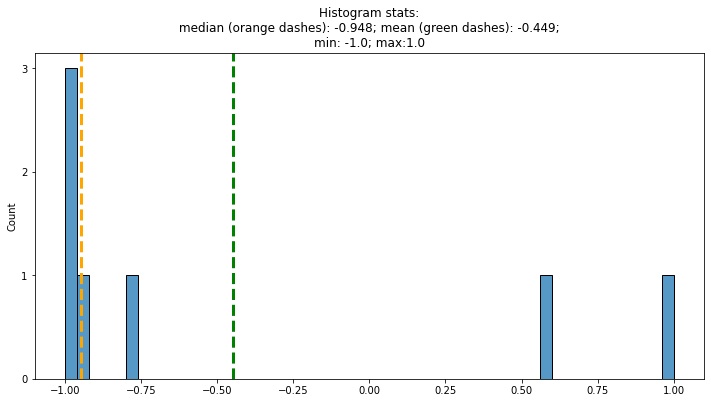

In [10]:
#Explore comment sentiment.  Type in a comment index number below.
comment_index = 80

comment_i = df.loc[comment_index,'sentences']
comment_i_sco = get_flair_scores(df.loc[comment_index,'sentences'])
comment_i_sco_avg = round(statistics.mean(comment_i_sco),3)

print(f"### Comment at index {comment_index} has {len(comment_i_sco)} sentences.  The mean flair score is {comment_i_sco_avg} ### \n")
cnt=1
for element in zip(comment_i, comment_i_sco):
    print(f'S{cnt}:', element)
    cnt+=1
get_histogram(comment_i_sco, log_scale_on=False, num_bins=50)

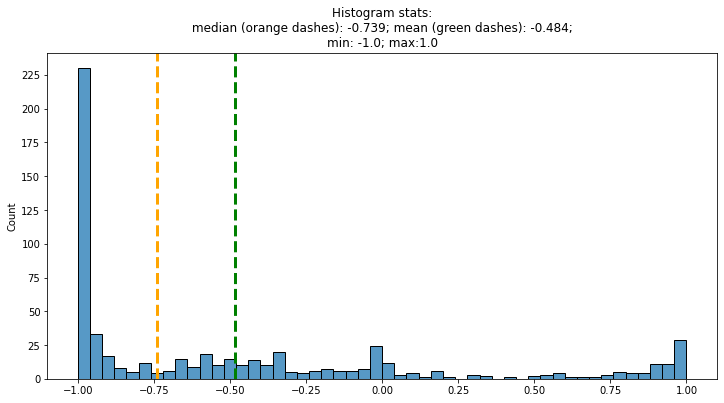

In [11]:
#Histogram of mean sentiment for 613 comments.  Means sentiment is the average sentiment of the sentences in a comment.
get_histogram(df.flair_sco_avg.values, log_scale_on=False, num_bins=50)

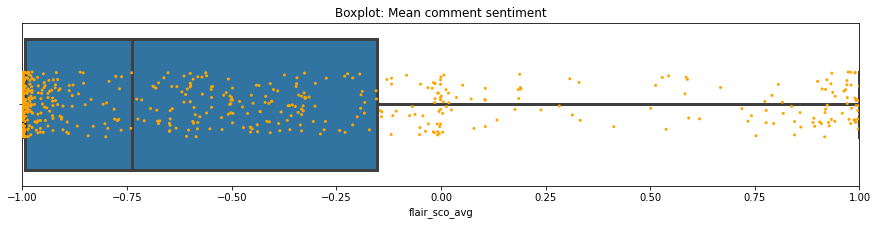

In [12]:
def plot_boxplot_w_data(colname, df, figsize=(15,3), title='Boxplot', xlimit=1):
    '''Returns boxplot with orange data points overlaid.'''
    fig, ax = plt.subplots(1,1,figsize=figsize)
    ax.set(xlim = (-1,xlimit))
    ax=sns.boxplot(x=colname, data=df, linewidth=3, fliersize=6)
    ax=sns.stripplot(x=colname, data=df, color="orange", jitter=0.2, size=3)  #Credit: https://python-graph-gallery.com/39-hidden-data-under-boxplot/
    ax.set_title(f'{title}')    
    plt.show()
    
plot_boxplot_w_data('flair_sco_avg', df, title='Boxplot: Mean comment sentiment')    

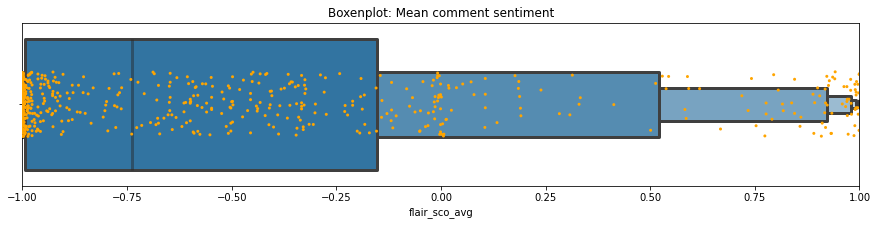

In [13]:
def plot_boxenplot_w_data(colname, df, figsize=(15,3), title='Boxplot', xlimit=1):
    '''Returns boxplot with orange data points overlaid.'''
    fig, ax = plt.subplots(1,1,figsize=figsize)
    ax.set(xlim = (-1,xlimit))
    ax=sns.boxenplot(x=colname, data=df, linewidth=3,)
    ax=sns.stripplot(x=colname, data=df, color="orange", jitter=0.2, size=3)  #Credit: https://python-graph-gallery.com/39-hidden-data-under-boxplot/
    ax.set_title(f'{title}')    
    plt.show()
    
plot_boxenplot_w_data('flair_sco_avg', df, title='Boxenplot: Mean comment sentiment')    

In [35]:
#In theory, these comments should be neutral on average.  
#In practice, we see the sentiment of a sentence (in a given comment) may be inaccurate.
filt = (df['flair_sco_avg'] > -0.01) & (df['flair_sco_avg'] < 0.01)
df.loc[filt]

,date,clean_date,comment,clean_comment,sentences,flair_sco,flair_sco_avg
8,11/10/21,2021-11-10,Phew good change! Now nobody will remember the dislikes on YouTube Rewind 2018,Phew good change! Now nobody will remember the dislikes on YouTube Rewind 2018,"[Phew good change!, Now nobody will remember the dislikes on YouTube Rewind 2018]","[1.0, -0.992]",0.004
49,11/10/21,2021-11-10,"This doesn't help small channels, this is to protect big brands. Just be honest about it.","This doesn't help small channels, this is to protect big brands. Just be honest about it.","[This doesn't help small channels, this is to protect big brands., Just be honest about it.]","[-0.971, 0.955]",-0.008
62,11/10/21,2021-11-10,"Small grammar correction:,> as long as you don’t display or share dislike data ,with end your users,.,I believe you meant: ,with your end users,(the alternative seems a bit morbid lol),Cheers","Small grammar correction:,> as long as you don’t display or share dislike data ,with end your users,. I believe you meant: ,with your end users,(the alternative seems a bit morbid lol),Cheers","[Small grammar correction:,> as long as you don’t display or share dislike data ,with end your users,., I believe you meant: ,with your end users,(the alternative seems a bit morbid lol),Cheers]","[-0.997, 0.979]",-0.009
86,11/11/21,2021-11-11,"Why not instead hide dislikes only for smaller creators then? Once you reach a certain threshold of views/subscribers, it becomes visible again.","Why not instead hide dislikes only for smaller creators then? Once you reach a certain threshold of views/subscribers, it becomes visible again.","[Why not instead hide dislikes only for smaller creators then?, Once you reach a certain threshold of views/subscribers, it becomes visible again.]","[-0.999, 0.999]",0.000
144,11/11/21,2021-11-11,"Censorship plain and simple. With any luck, these kind of actions are gonna drive an alternative to these Big Tech platforms pretty soon.","Censorship plain and simple. With any luck, these kind of actions are gonna drive an alternative to these Big Tech platforms pretty soon.","[Censorship plain and simple., With any luck, these kind of actions are gonna drive an alternative to these Big Tech platforms pretty soon.]","[-0.991, 0.992]",0.001
149,11/11/21,2021-11-11,"If you don't use the Dislike function, THEN YOU FUCKING DON'T UNDERSTAND IT!,OR HAVE SEEN THE MILLIONS OF DISLIKES YT HAVE REVOVED FROM DADY BYDEN! ,F YOU SIMP!","If you don't use the Dislike function, THEN YOU FUCKING DON'T UNDERSTAND IT!,OR HAVE SEEN THE MILLIONS OF DISLIKES YT HAVE REVOVED FROM DADY BYDEN! F YOU SIMP!","[If you don't use the Dislike function, THEN YOU FUCKING DON'T UNDERSTAND IT!,OR HAVE SEEN THE MILLIONS OF DISLIKES YT HAVE REVOVED FROM DADY BYDEN!, F YOU SIMP!]","[-0.999, 0.983]",-0.008
153,11/11/21,2021-11-11,people will just not bother using YouTube client and login since the reason I'm login in is so i can like and dislike things to help others not mislead by video. So probably people will just immediately report and since YouTube cs known to be biased when reviewing report so people will not even bother reporting and start looking other platform. You're doing great job at de-platforming your community in my opinion. Remember opinion do matters in world with free system and yours give reason p...,people will just not bother using YouTube client and login since the reason I'm login in is so i can like and dislike things to help others not mislead by video. So probably people will just immediately report and since YouTube cs known to be biased when reviewing report so people will not even bother reporting and start looking other platform. You're doing great job at de-platforming your community in my opinion. Remember opinion do matters in world with free system and yours give reason p...,"[people will just not bother using YouTube client and login since the reason I'm login in is so i can like and dislike things to help others not mislead by v

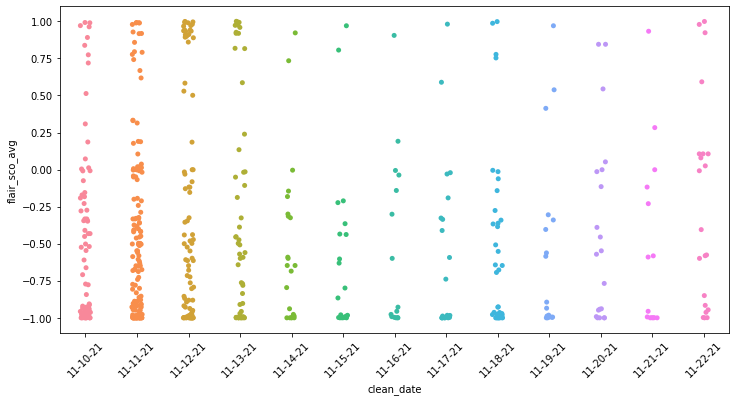

In [27]:
#Stripplot.
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax = sns.stripplot(x='clean_date', y='flair_sco_avg', data=df)
x_dates = df['clean_date'].dt.strftime('%m-%d-%y').sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=45)
plt.show()

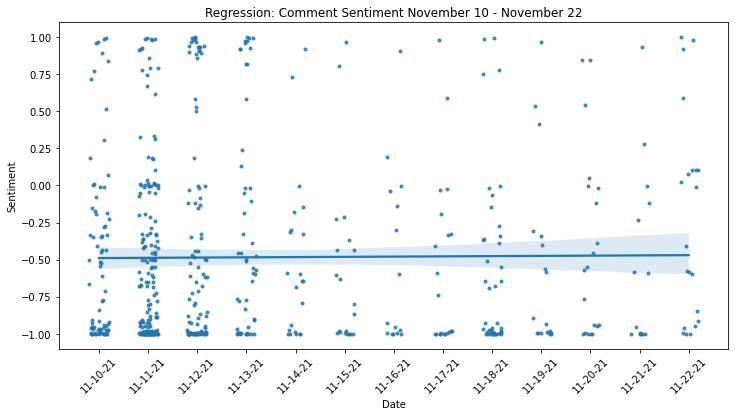

In [33]:
#Regplot of sentiment.  Uses hacks to put datetime64 on x-axis.
import matplotlib.ticker as mticker

fig, ax = plt.subplots(1,1,figsize=(12,6))
factorized = pd.factorize(df['clean_date'])[0] + 1
mapping = dict(zip(factorized, df['clean_date'].dt.strftime('%m-%d-%y')))
ax.set(xticks=np.arange(1, len(mapping)+1, 1))  #set proper number of xticks--13
labels = pd.Series(ax.get_xticks()).map(mapping).fillna('')

ax = sns.regplot(x=factorized, y='flair_sco_avg', data=df, marker='.', x_jitter=0.2)
ax.xaxis.set_major_locator(mticker.FixedLocator(ax.get_xticks().tolist(),nbins=100))
ax.set_xticklabels(labels, rotation=45)
ax.set_title('Regression: Comment Sentiment November 10 - November 22')
ax.set_xlabel('Date')
ax.set_ylabel('Sentiment')
plt.show()

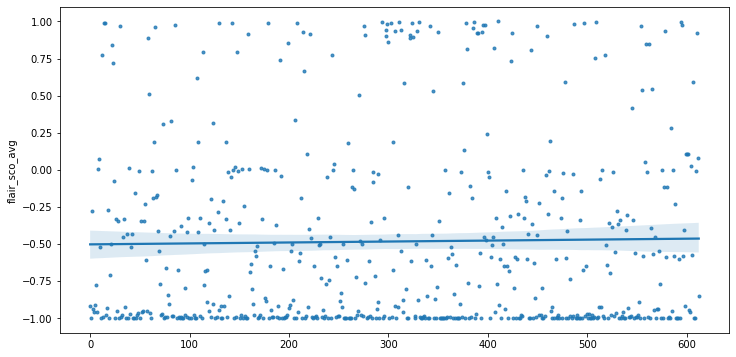

In [29]:
#Verify regression makes sense using oldest to newest comments 0-612.
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax = sns.regplot(x=df.index, y='flair_sco_avg', data=df, marker='.', x_jitter=0.2)

In [ ]:
# #Get histogram of flair scores for all sentences in corpus of comments.
# import itertools
# scores = []
# for idx in df.index:
#     sentences_scores = df.loc[idx, 'flair_sco']
#     scores.append(sentences_scores)   

# flat_scores = list(itertools.chain(*scores))
# flat_scores[-10:]

# get_histogram(flat_scores, log_scale_on=False, num_bins=30)

In [ ]:
# fig, (ax1, ax2) = plt.subplots(2,1,figsize=(14,16))
# sns.regplot(x=df.index, y=df.flair_sco_avg, data=df, marker='.', ax=ax1)
# sns.histplot(x=df.flair_sco_avg, data=df, bins=50, ax=ax2)
# ax1.set_title('Linear Regression:  Mean Comment Sentiment - Oldest to Newest Comment')
# ax1.set_xlabel('Comment Number')
# ax1.set_ylabel('Sentiment')

# ax2.set_title('Histogram:  Mean Comment Sentiment')
# ax2.set_xlabel('Sentiment')
# ax2.set_ylabel('Sentiment Count')
# plt.show()